In [1]:
#공통으로 설정할것 

from IPython.display import display
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import mglearn

from sklearn.model_selection import train_test_split
# train , test data 나눠줄때 사용하는 것 

import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
# 위에것은 교과서에 없는 내용인데, 숫자 마이너스 부호 깨질때 쓰는거임 

import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/malgunbd.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
# 폰트 계속 깨져서 폰트 설정 
# 이건 책에 없는거임 

In [2]:
# [PR #9151](https://github.com/scikit-learn/scikit-learn/pull/9151)에서 가져온 CategoricalEncoder 클래스의 정의.
# 이 클래스는 사이킷런 0.20에 포함될 예정입니다.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

# 1. 데이터 전처리 ver.1

In [1]:
import pandas as pd
data = pd.read_excel( "C:/Users/HOME/Desktop/빅리더 양성과정/7조 팀플/한글로바꾼샘플데이터.xlsx" )


In [2]:
# # data.head()
# data.info()
data.columns
# data.describe()


Index(['자료 순번', '연령대', 'B_AREA_CD_M', '도시', '시군구', '자료추출기준일', '신용평점', '목적값',
       '주거용부동산 보유여부', '자가거주 여부', '주택유형', '(추정) 월평균 연소득', '(주거용) 부동산 자산보유수',
       '(주거용) 부동산 자산공시금액', '대출보유(기관)수', '총부채잔액', '신용대출잔액', '주택담보대출잔액',
       '주택외담보대출잔액', '기타대출잔액', '월평균상환원금금액합계', '월평균상환이자금액합계', '평균부담대출이자율',
       '월평균총신용카드이용금액', '월평균(신용카드)일시불이용금액', 'DTI', 'DSR', '평균평형별매매가',
       '평균평형별전세가', '최초신용카드개설일자로부터경과일수[법인카드]',
       '은행업종최근신용대출개설일자(생활안정/창업/기타자금목적)(1개월내신규개설)[기업여신]', '대출총건수(미해지)[기업여신]',
       '저축은행업종대출총건수(미해지)[기업여신]', '저축은행업권 대출총약정금액(미해지)[기업여신]',
       '운전자금(신용정보원계정과목)대출총약정금액(1개월내신규개설)(미해지)', '대출총약정금액(미해지)[기업여신]',
       '대출총기관수(미해지)[기업여신]', '할부금융업종대출총기관수(미해지)[기업여신]',
       '저축은행업종대출총잔액(미해지)[기업여신]', '대출총잔액(미해지)[기업여신]', '은행업종대출총잔액(미해지)[기업여신]',
       '할부금융업종대출총잔액(미해지)[기업여신]', '총연체금액(미해제)[법인카드]', '총연체금액(미해제)[기업여신/법인카드]',
       '미해제연체총기관수[기업여신/법인카드]', 'Unnamed: 45', '최장연체일수(해제포함)[기업여신/사업자카드]',
       '총연체일수(1년내유지)(해제포함)[기업여신/사업자카드]', '최초신용카드개설일자로부터경과일수[법인카드].1',
       '1개월전(15일)카드일시불총이용

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47308 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49692 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47161 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44428 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50557 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50868 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44508 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 54624 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Anaconda3\lib\site-packages\mat

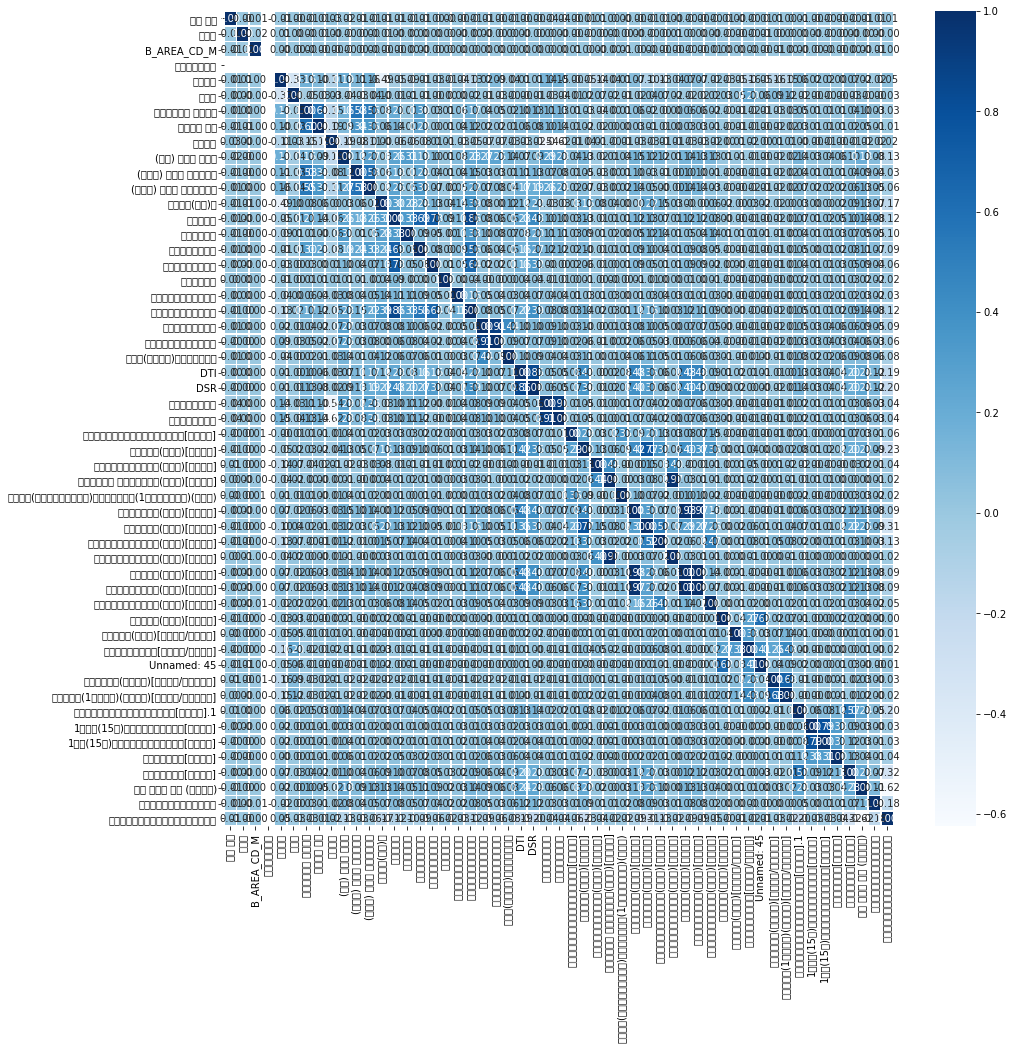

In [3]:
# 그래프 상관관계로 표현하기 
%matplotlib inline   
import matplotlib.pyplot as plt 
import seaborn as sns   

plt.figure(figsize=(15,15))
sns.heatmap(data = data.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

plt.show()

corr_matrix = data.corr()
corr_matrix["목적값"].sort_values(ascending=False)
data_1 = data[['미해제연체총기관수[기업여신/법인카드]','총연체일수(1년내유지)(해제포함)[기업여신/사업자카드]',
              '대출보유(기관)수','최장연체일수(해제포함)[기업여신/사업자카드]','저축은행업종대출총건수(미해지)[기업여신]',
               '총연체금액(미해제)[기업여신/법인카드]','대출총기관수(미해지)[기업여신]','주택유형',
              '신용평점','주거용부동산 보유여부','(추정) 월평균 연소득','(주거용) 부동산 자산공시금액','목적값']]

In [24]:
data["목적값"].corr(data["신용평점"])

-0.33123131377366166

In [22]:
data["목적값"].corr(data["미해제연체총기관수[기업여신/법인카드]"])

0.19567940237133444

In [25]:
data["목적값"].corr(data["총연체일수(1년내유지)(해제포함)[기업여신/사업자카드]"])

0.12431851842264738

In [26]:
data["목적값"].corr(data["대출보유(기관)수"])

0.0971020433737632

In [27]:
data["목적값"].corr(data["최장연체일수(해제포함)[기업여신/사업자카드]"])

0.08521672559787427

In [31]:
data.describe()

,자료 순번,연령대,B_AREA_CD_M,자료추출기준일,신용평점,목적값,주거용부동산 보유여부,자가거주 여부,주택유형,(추정) 월평균 연소득,...,최장연체일수(해제포함)[기업여신/사업자카드],총연체일수(1년내유지)(해제포함)[기업여신/사업자카드],최초신용카드개설일자로부터경과일수[법인카드].1,1개월전(15일)카드일시불총이용금액[법인카드],1년내(15일)카드일시불최고총이용금액[법인카드],카드총이용잔액[법인카드],신용카드기관수[법인카드],소유 사업체 건수 (폐업제외),최초폐업일자로부터경과일수,사업자정보최초등록일자로부터경과일수
count,64825.000000,64825.000000,64825.000000,64825.0,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,...,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,6.482500e+04
mean,32413.000000,45.084844,34023.259730,20180630.0,826.994030,0.025407,0.442083,0.219221,1.537077,332.940964,...,2.031315,1.436730,460.531539,363.007867,677.869464,381.120247,0.496691,0.704960,569.661242,1.681159e+08
std,18713.509937,11.235041,12974.301839,0.0,137.548351,0.176663,0.496638,0.413722,0.498627,214.496680,...,33.703527,28.430655,969.046625,5785.659951,8474.317003,4229.023154,0.649708,0.511093,1453.247102,3.739697e+08
min,1.000000,20.000000,11110.000000,20180630.0,0.000000,0.000000,0.000000,0.000000,1.000000,83.000000,...,0.000000,0.000000,0.000000,-3699.000000,0.000000,0.000000,0.000000,0.000000,-751.000000,1.000000e+00
25%,16207.000000,40.000000,26470.000000,20180630.0,750.000000,0.000000,0.000000,0.000000,1.000000,233.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000e+03
50%,32413.000000,50.000000,41210.000000,20180630.0,867.000000,0.000000,0.000000,0.000000,2.000000,267.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.708000e+03
75%,48619.000000,50.000000,44210.000000,20180630.0,930.000000,0.000000,1.000000,0.000000,2.000000,350.000000,...,0.000000,0.000000,485.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.866000e+03
max,64825.000000,70.000000,50130.000000,20180630.0,1000.000000,2.000000,1.000000,1.000000,2.000000,1556.000000,...,2089.000000,1975.000000,9468.000000,711395.000000,909800.000000,747999.000000,5.000000,5.000000,13788.000000,1.000000e+09


In [4]:
# data_1.head()
list(data_1)
#추정 월 평균 소득 / 신용평점 / 부동산 자산공시금액 
print(data['(추정) 월평균 연소득'].value_counts(ascending=False))
print(data['신용평점'].value_counts)

258     3830
233     3717
267     3648
242     2742
250     2658
        ... 
1129       1
1464       1
1168       1
1193       1
822        1
Name: (추정) 월평균 연소득, Length: 1312, dtype: int64
<bound method IndexOpsMixin.value_counts of 0        917
1        723
2        921
3        843
4        675
        ... 
64820    908
64821    461
64822    882
64823    537
64824    970
Name: 신용평점, Length: 64825, dtype: int64>


In [5]:
data_1.describe()

,미해제연체총기관수[기업여신/법인카드],총연체일수(1년내유지)(해제포함)[기업여신/사업자카드],대출보유(기관)수,최장연체일수(해제포함)[기업여신/사업자카드],저축은행업종대출총건수(미해지)[기업여신],총연체금액(미해제)[기업여신/법인카드],대출총기관수(미해지)[기업여신],주택유형,신용평점,주거용부동산 보유여부,(추정) 월평균 연소득,(주거용) 부동산 자산공시금액,목적값
count,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000,64825.000000
mean,0.002823,1.436730,1.367944,2.031315,0.014917,40.370752,0.454254,1.537077,826.994030,0.442083,332.940964,17494.642036,0.025407
std,0.060399,28.430655,1.340805,33.703527,0.153459,3342.107402,0.658728,0.498627,137.548351,0.496638,214.496680,36022.812698,0.176663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,83.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,750.000000,0.000000,233.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,867.000000,0.000000,267.000000,0.000000,0.000000
75%,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,2.000000,930.000000,1.000000,350.000000,23400.000000,0.000000
max,4.000000,1975.000000,9.000000,2089.000000,6.000000,635554.000000,6.000000,2.000000,1000.000000,1.000000,1556.000000,805354.000000,2.000000


In [8]:
import numpy as np

In [9]:
# data_1['(주거용) 부동산 자산공시금액'] = np.ceil(data_1['(주거용) 부동산 자산공시금액']/1000)
data_1["신용평점"] = np.round(data_1["신용평점"]/100) 
data_1["(추정) 월평균 연소득"] = np.round(data_1["(추정) 월평균 연소득"]/100) 

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
data_1["신용평점"].value_counts()

9.0     24430
8.0     13281
10.0    10978
7.0      8281
6.0      5162
5.0      1738
4.0       428
3.0       281
2.0       198
1.0        38
0.0        10
Name: 신용평점, dtype: int64

In [11]:
data_1.head()
data_1.describe()
data_1.columns

Index(['미해제연체총기관수[기업여신/법인카드]', '총연체일수(1년내유지)(해제포함)[기업여신/사업자카드]', '대출보유(기관)수',
       '최장연체일수(해제포함)[기업여신/사업자카드]', '저축은행업종대출총건수(미해지)[기업여신]',
       '총연체금액(미해제)[기업여신/법인카드]', '대출총기관수(미해지)[기업여신]', '주택유형', '신용평점',
       '주거용부동산 보유여부', '(추정) 월평균 연소득', '(주거용) 부동산 자산공시금액', '목적값'],
      dtype='object')

In [12]:
data_1['목적값'] = data_1['목적값'].replace(2,1)
# 2를 1로 바꿔줌 
data_1["목적값"].value_counts()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0    63387
1     1438
Name: 목적값, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

X= data_1[['미해제연체총기관수[기업여신/법인카드]', '총연체일수(1년내유지)(해제포함)[기업여신/사업자카드]', '대출보유(기관)수',
       '최장연체일수(해제포함)[기업여신/사업자카드]', '저축은행업종대출총건수(미해지)[기업여신]',
       '총연체금액(미해제)[기업여신/법인카드]', '대출총기관수(미해지)[기업여신]', '주택유형', '신용평점',
       '주거용부동산 보유여부', '(추정) 월평균 연소득', '(주거용) 부동산 자산공시금액']]
y = data_1[['목적값']]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=50)

### 데이터 스케일링

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

In [19]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# 모델설정
sm = SMOTE()

# train데이터를 넣어 복제함
X_resampled, y_resampled = sm.fit_sample(X_train,list(y_train))

print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(X_resampled.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_resampled==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_resampled==0)))

ValueError: Found input variables with inconsistent numbers of samples: [48618, 1]

In [62]:
from sklearn.linear_model import LinearRegression

mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_predict = mlr.predict(X_test)

In [63]:

print("훈련 세트 점수: {:.2f}".format(mlr.score(X_train, y_train)))
print("테스트 세트 점수: {:.2f}".format(mlr.score(X_test, y_test)))

훈련 세트 점수: 0.16
테스트 세트 점수: 0.13


In [64]:
data_1.head()

,미해제연체총기관수[기업여신/법인카드],총연체일수(1년내유지)(해제포함)[기업여신/사업자카드],대출보유(기관)수,최장연체일수(해제포함)[기업여신/사업자카드],저축은행업종대출총건수(미해지)[기업여신],총연체금액(미해제)[기업여신/법인카드],대출총기관수(미해지)[기업여신],주택유형,신용평점,주거용부동산 보유여부,(추정) 월평균 연소득,(주거용) 부동산 자산공시금액,목적값
0,0,0,0,0,0,0,0,1,9.0,0,2.0,0,0
1,0,0,3,0,0,0,0,2,7.0,0,5.0,0,0
2,0,0,1,0,0,0,0,1,9.0,1,2.0,25954,0
3,0,0,0,0,0,0,0,2,8.0,0,2.0,0,0
4,0,0,1,0,0,0,1,2,7.0,0,2.0,0,0


In [65]:
from sklearn.linear_model import LogisticRegression
import mglearn
import statsmodels.api as sm

logreg = LogisticRegression().fit(X_train, y_train)
#f통계량 크면 선형이 잘 안그려짐 
x2 = sm.add_constant(X)
model = sm.OLS(y,x2)
result= model.fit()
print(result.summary())
print("훈련 세트 점수: {:.3f}".format(logreg.score(X_train, y_train)))
print("테스트 세트 점수: {:.3f}".format(logreg.score(X_test, y_test)))

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                            OLS Regression Results                            
Dep. Variable:                    목적값   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     991.5
Date:                Sat, 15 Aug 2020   Prob (F-statistic):               0.00
Time:                        01:11:31   Log-Likelihood:                 37648.
No. Observations:               64825   AIC:                        -7.527e+04
Df Residuals:                   64812   BIC:                        -7.515e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [60]:
logreg001 = LogisticRegression(C=0.01).fit(X_train, y_train)
print("훈련 세트 점수: {:.3f}".format(logreg001.score(X_train, y_train)))
print("테스트 세트 점수: {:.3f}".format(logreg001.score(X_test, y_test)))


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 세트 점수: 0.978
테스트 세트 점수: 0.979


C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [42]:
logreg100 = LogisticRegression(C=100).fit(X_train, y_train)
print("훈련 세트 점수: {:.3f}".format(logreg100.score(X_train, y_train)))
print("테스트 세트 점수: {:.3f}".format(logreg100.score(X_test, y_test)))

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 세트 점수: 0.979
테스트 세트 점수: 0.980


C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [43]:
from sklearn.metrics import confusion_matrix


prediction =  logreg001.predict(X_test)
confusion = confusion_matrix(y_true=y_test, y_pred=prediction)
print(confusion)


[[15859     8]
 [  305    35]]


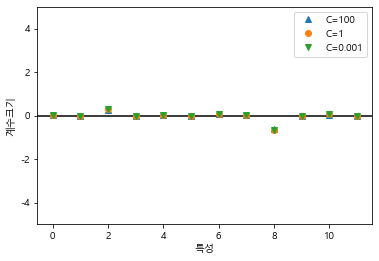

In [44]:
# C의 설정만 세가지로 설정하여 plotting 해보자 

plt.plot(logreg100.coef_.T, '^', label="C=100")
plt.plot(logreg.coef_.T, 'o', label='C=1')
plt.plot(logreg001.coef_.T, 'v', label='C=0.001')
# plt.xticks(range(cancer.data.shape[1]), cancer.feature_names, rotation=90)
# xticks -> 특성 계수 갯수 
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
# hlines -> 가로 및 세로 선 그리는 것 
plt.xlim(xlims)
# x 축 제한 
plt.ylim(-5,5)
plt.xlabel("특성")
plt.ylabel("계수크기")
plt.legend()